In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import sympy
import argparse

import equations
import data
from gp_utils import run_gp

import sympy

import sys
import os
directory_path = os.getcwd()
sys.path.append(directory_path + '/gplearn/')
from gplearn.genetic import SymbolicRegressor
from utils import generator
from interpolate import get_ode_data
from config import get_interpolation_config
from integrate import generate_grid
import pandas as pds

## True and smoothed trajectaries

In [9]:
def get_plot(ode_name, noise_ratio, n_sample=50, freq=10, x_id=0, ode_param=None, key='noise'):
    df = pds.read_csv('results/{}-{}.txt'.format('GompertzODE', key), header=None)
    df.columns = ['ode', 'freq', 'n', 'sigma', 'method', 'rate', 'rate_sd', 'ks', 'ks_sd']
    df['del_t'] = 1. / df['freq']
    if key == 'noise':
        success_prob = df[(df.method=='vi') & (df.sigma==noise_ratio)]['rate'].values[0]
    else:
        success_prob = df[(df.method=='vi') & (df.freq==freq)]['rate'].values[0]


    np.random.seed(999)

    ode = equations.get_ode(ode_name, ode_param)
    T = ode.T
    init_low = ode.init_low
    init_high = ode.init_high

    noise_sigma = ode.std_base * noise_ratio

    dg = data.DataGenerator(ode, T, freq, n_sample, noise_sigma, init_low, init_high)
    yt = dg.generate_data()

    ode_data, X_ph, y_ph, t_new = get_ode_data(yt, x_id, dg, ode)


    config = get_interpolation_config(ode, 0)
    freq_int = config['freq_int']
    t_new, weight = generate_grid(dg.T, freq_int)
    t = dg.solver.t

    i = 0

    if ode_name == 'GompertzODE':
        plt.ylim(-0.1, 1.55)
        
    plt.plot(t, yt[:, i, x_id], '.', label='$y(t)$')
    plt.plot(t, dg.xt[:, i, x_id], label='$x(t)$')

    plt.plot(t_new, ode_data['x_hat'][:, i, x_id], color=colors[3], label='$\hat{x}(t)$')
    

    plt.xlabel(r'$t$', size=16)
    plt.title('{}: $\sigma_R={}$, $\Delta t={}$\nSuccess Prob={}'.format(ode_name, noise_ratio, 1/freq, success_prob))

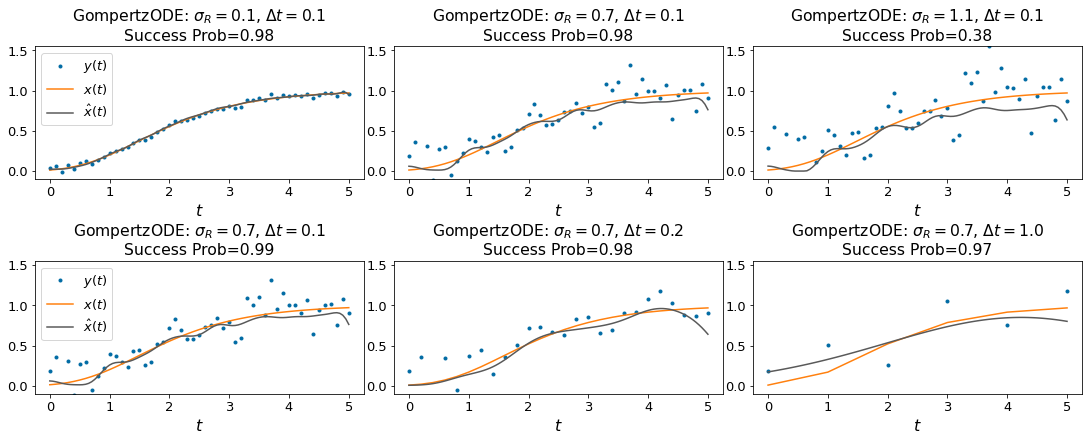

In [23]:
plt.figure(figsize=(15, 6))
plt.style.use('tableau-colorblind10')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['font.size'] = '13'

plt.subplot(231)

get_plot(ode_name = 'GompertzODE',
        noise_ratio = 0.1,
        n_sample = 50,
        freq = 10,
        x_id = 0,
        ode_param=None)

plt.legend()

plt.subplot(232)

get_plot(ode_name = 'GompertzODE',
        noise_ratio = 0.7,
        n_sample = 50,
        freq = 10,
        x_id = 0,
        ode_param=None)

plt.subplot(233)

get_plot(ode_name = 'GompertzODE',
        noise_ratio = 1.1,
        n_sample = 50,
        freq = 10,
        x_id = 0,
        ode_param=None)

# sparsity

plt.subplot(234)

get_plot(ode_name = 'GompertzODE',
        noise_ratio = 0.7,
        n_sample = 50,
        freq = 10,
        x_id = 0,
        ode_param=None,
        key='freq')

plt.legend()

plt.subplot(235)

get_plot(ode_name = 'GompertzODE',
        noise_ratio = 0.7,
        n_sample = 50,
        freq = 5,
        x_id = 0,
        ode_param=None,
        key='freq')


plt.subplot(236)

get_plot(ode_name = 'GompertzODE',
        noise_ratio = 0.7,
        n_sample = 50,
        freq = 1,
        x_id = 0,
        ode_param=None,
        key='freq')

# lorenz

# plt.subplot(234)

# get_plot(ode_name = 'Lorenz',
#         noise_ratio = 0.09,
#         n_sample = 50,
#         freq = 10,
#         x_id = 0,
#         ode_param=None)

# plt.legend()

# plt.subplot(235)

# get_plot(ode_name = 'Lorenz',
#         noise_ratio = 0.2,
#         n_sample = 50,
#         freq = 10,
#         x_id = 0,
#         ode_param=None)

# plt.subplot(236)

# get_plot(ode_name = 'Lorenz',
#         noise_ratio = 0.3,
#         n_sample = 50,
#         freq = 10,
#         x_id = 0,
#         ode_param=None)

plt.tight_layout(pad=0.2)

plt.savefig('rebuttal_traj.png', dpi=200)

# computaion time comparision with DO

In [246]:
from scipy.optimize import minimize
import time

In [262]:
def DO_time(ode_name):
    time_list = []
    fev_list = []
    np.random.seed(999)

    for i in range(100):
        
        noise_ratio = 0.1
        n_sample = 5
        freq = 10
        x_id = 0
        ode_param = None

        ode = equations.get_ode(ode_name, ode_param)
        T = ode.T
        init_low = ode.init_low
        init_high = ode.init_high

        noise_sigma = ode.std_base * noise_ratio

        dg = data.DataGenerator(ode, T, freq, n_sample, noise_sigma, init_low, init_high)
        yt = dg.generate_data()

        init_cond0 = yt[0, :, 0]
        bounds = [(0., np.inf)] * len(init_cond0)

        s = time.time()
        def obj(init_cond):
            init_cond[init_cond <= 0] = 1e-9
            init_cond = init_cond[:, None]
            try:
                xt = dg.solver.solve(init_cond)
            except ValueError:
                xt = np.zeros_like(yt)
            return np.mean((yt - xt) ** 2)

        res = minimize(obj, init_cond0, method='L-BFGS-B', bounds=bounds)
        e = time.time()
        time_list.append(e - s)
        fev_list.append(res.nfev)
    time_list1 = np.array(time_list)
    return time_list1

In [264]:
time_list1 = DO_time('LogisticODE')

In [265]:
time_list1g = DO_time('GompertzODE')

In [268]:
# D-CODE

def DCODE_time(ode_name):
    time_list = []
    np.random.seed(999)

    for i in range(100):

        noise_ratio = 0.1
        n_sample = 5
        freq = 10
        x_id = 0
        ode_param = None

        ode = equations.get_ode(ode_name, ode_param)
        T = ode.T
        init_low = ode.init_low
        init_high = ode.init_high

        noise_sigma = ode.std_base * noise_ratio

        dg = data.DataGenerator(ode, T, freq, n_sample, noise_sigma, init_low, init_high)
        yt = dg.generate_data()
        s = time.time()

        ode_data, X_ph, y_ph, t_new = get_ode_data(yt, x_id, dg, ode)

         # T B D
        x_hat = ode_data['x_hat']
        # T, K
        g = ode_data['g']
        # B, K
        c = ode_data['c']
        # T
        integration_weights = ode_data['weights']

        T, B, D = x_hat.shape

        x_hat_long = x_hat.reshape((T * B, D))


        y_hat_long = ode._dx_dt(x_hat_long.squeeze())[0]

        y_hat = y_hat_long.reshape((T, B))

        c_hat = (y_hat * integration_weights[:, None]).T @ g

        e1 = np.mean((c + c_hat) ** 2)
        e = time.time()
        time_list.append(e - s)
    return np.array(time_list)

In [269]:
time_list2 = DCODE_time('LogisticODE')

In [270]:
time_list2g = DCODE_time('GompertzODE')

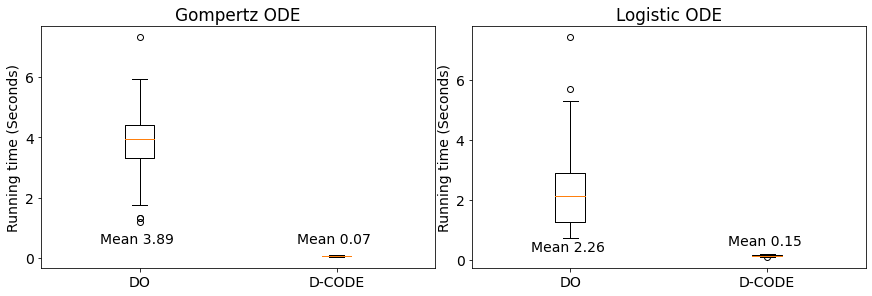

In [304]:
plt.figure(figsize=(12, 4))
plt.style.use('tableau-colorblind10')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['font.size'] = '14'


plt.subplot(121)
plt.boxplot([time_list1g, time_list2g])
plt.text(x=0.8, y=0.5, s='Mean {}'.format(round(np.mean(time_list1g), 2)))
plt.text(x=1.8, y=0.5, s='Mean {}'.format(round(np.mean(time_list2g), 2)))
plt.xticks(ticks=[1, 2], labels=['DO', 'D-CODE'])
plt.ylabel('Running time (Seconds)')
plt.title('Gompertz ODE')

plt.subplot(122)
plt.boxplot([time_list1, time_list2])
plt.text(x=0.8, y=0.3, s='Mean {}'.format(round(np.mean(time_list1), 2)))
plt.text(x=1.8, y=0.5, s='Mean {}'.format(round(np.mean(time_list2), 2)))
plt.xticks(ticks=[1, 2], labels=['DO', 'D-CODE'])
plt.ylabel('Running time (Seconds)')
plt.title('Logistic ODE')


plt.tight_layout(pad=0.2)

plt.savefig('rebuttal_time.png', dpi=200)

## Node + symbolic

In [306]:
method_dict = {
    'vi': 'D-CODE',
    'node': 'NODE-L',
    'node_one_step': 'NODE-S',
}
val_dict = {
    'noise': 'sigma',
}

In [319]:
ode_list = ['GompertzODE']
def plot_df(df, x_val='sigma'):
    for method in method_dict.keys():
        df_sub = df[df.method == method]
        df_sub = df_sub.dropna()

        plt.fill_between(df_sub[x_val], df_sub.rate - df_sub.rate_sd, df_sub.rate + df_sub.rate_sd, alpha=0.3)

        plt.plot(df_sub[x_val], df_sub.rate, 'o-', label=method_dict[method])
        plt.ylim(-0.05, 1.05)
        

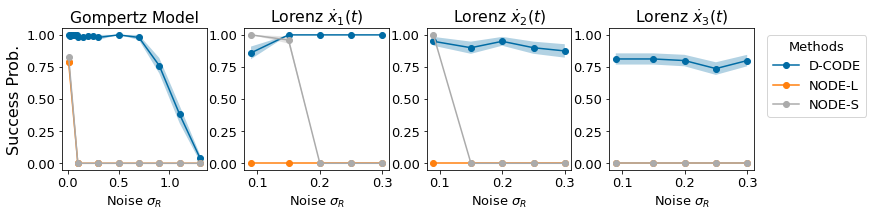

In [320]:
plt.figure(figsize=(12, 3))
plt.style.use('tableau-colorblind10')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['font.size'] = '13'

counter = 1
for i in range(len(ode_list)):
    ode = ode_list[i]
    for val_key, x_val in val_dict.items():
        df = pds.read_csv('results/{}-{}.txt'.format(ode, val_key), header=None)

        df.columns = ['ode', 'freq', 'n', 'sigma', 'method', 'rate', 'rate_sd', 'ks', 'ks_sd']
        df['del_t'] = 1. / df['freq']
        df = df.sort_values(['method', x_val])

        plot_conf = 140 + counter
        plt.subplot(plot_conf)
        plot_df(df, x_val=x_val)
        
        if counter == 1 or counter == 4:
            plt.ylabel('Success Prob.', size=16)
            
        if counter == 1:
            plt.title('Gompertz Model')
#             plt.xscale('log')
        elif counter == 2:
            plt.title('Gompertz Model \n Varying step size $\Delta t$')
            plt.xscale('log')
        elif counter == 3:
            plt.title('Varying sample size $N$')
        elif counter == 5:
            plt.title('Generalized Logistic Model')
            
        if counter == 4:
            plt.xlabel(r'$\sigma_R$', size=16)
            plt.xscale('log')
        elif counter == 5:
            plt.xlabel(r'$\Delta t$', size=16)
            plt.xscale('log')
        elif counter == 6:
            plt.xlabel(r'$N$', size=16)
        plt.xlabel('Noise $\sigma_R$')
        counter += 1
        

for i in range(3):
    plot_conf = 140 + counter
    plt.subplot(plot_conf)

    x_id = i

    if x_id == 0:
        df = pds.read_csv('results/Lorenz-noise.txt', header=None)
    else:
        df = pds.read_csv('results/Lorenz-noise-{}.txt'.format(x_id), header=None)


    df.columns = ['ode', 'freq', 'n', 'sigma', 'method', 'rate', 'rate_sd', 'ks', 'ks_sd']
    df['del_t'] = 1. / df['freq']
    df = df.sort_values(['method', 'sigma'])
    plot_df(df)
    plt.xlabel('Noise $\sigma_R$')
    if i == 0:
        plt.title('Lorenz $\dot{x}_1(t)$')
    elif i == 1:
        plt.title('Lorenz $\dot{x}_2(t)$')
    else:
        plt.title('Lorenz $\dot{x}_3(t)$')

        plt.legend(bbox_to_anchor=(1.005, 1), loc='upper left', fontsize=10)

    counter += 1
            
plt.legend(title='Methods', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout(pad=0.5)
plt.savefig('rebuttal_node_prob.png', dpi=200)

In [321]:
def plot_df(df, x_val='sigma'):
    for method in method_dict.keys():
        df_sub = df[df.method == method]
        df_sub = df_sub.dropna()
        
#         if x_val == 'sigma':
#             df_sub = df_sub[df_sub[x_val] < 0.6]

        plt.fill_between(df_sub[x_val], df_sub.ks - df_sub.ks_sd, df_sub.ks + df_sub.ks_sd, alpha=0.3)

        plt.plot(df_sub[x_val], df_sub.ks, 'o-', label=method_dict[method])
#         plt.ylim([-0.05, None])
        

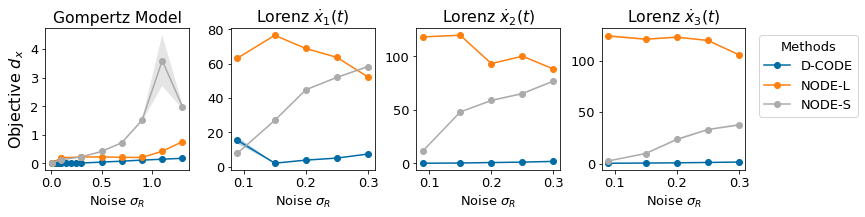

In [322]:
plt.figure(figsize=(12, 3))
plt.style.use('tableau-colorblind10')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['font.size'] = '13'

counter = 1
for i in range(len(ode_list)):
    ode = ode_list[i]
    for val_key, x_val in val_dict.items():
        df = pds.read_csv('results/{}-{}.txt'.format(ode, val_key), header=None)

        df.columns = ['ode', 'freq', 'n', 'sigma', 'method', 'rate', 'rate_sd', 'ks', 'ks_sd']
        df['del_t'] = 1. / df['freq']
        df = df.sort_values(['method', x_val])

        plot_conf = 140 + counter
        plt.subplot(plot_conf)
        plot_df(df, x_val=x_val)
        
        if counter == 1 or counter == 4:
            plt.ylabel('Objective $d_x$', size=16)
            
        if counter == 1:
            plt.title('Gompertz Model')
#             plt.xscale('log')
        elif counter == 2:
            plt.title('Gompertz Model \n Varying step size $\Delta t$')
            plt.xscale('log')
        elif counter == 3:
            plt.title('Varying sample size $N$')
        elif counter == 5:
            plt.title('Generalized Logistic Model')
            
        if counter == 4:
            plt.xlabel(r'$\sigma_R$', size=16)
            plt.xscale('log')
        elif counter == 5:
            plt.xlabel(r'$\Delta t$', size=16)
            plt.xscale('log')
        elif counter == 6:
            plt.xlabel(r'$N$', size=16)
        plt.xlabel('Noise $\sigma_R$')
        counter += 1
        

for i in range(3):
    plot_conf = 140 + counter
    plt.subplot(plot_conf)

    x_id = i

    if x_id == 0:
        df = pds.read_csv('results/Lorenz-noise.txt', header=None)
    else:
        df = pds.read_csv('results/Lorenz-noise-{}.txt'.format(x_id), header=None)


    df.columns = ['ode', 'freq', 'n', 'sigma', 'method', 'rate', 'rate_sd', 'ks', 'ks_sd']
    df['del_t'] = 1. / df['freq']
    df = df.sort_values(['method', 'sigma'])
    plot_df(df)
    plt.xlabel('Noise $\sigma_R$')
    if i == 0:
        plt.title('Lorenz $\dot{x}_1(t)$')
    elif i == 1:
        plt.title('Lorenz $\dot{x}_2(t)$')
    else:
        plt.title('Lorenz $\dot{x}_3(t)$')

        plt.legend(bbox_to_anchor=(1.005, 1), loc='upper left', fontsize=10)

    counter += 1
            
plt.legend(title='Methods', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout(pad=0.5)
plt.savefig('rebuttal_node_dist.png', dpi=200)